## Reconstruction momentum model

In this section we will work with simple model, which consist only momentum final particles. Also, we will reconstruct only momentum for internal particle. Let's start with example, consider decay $K_S \to \pi^+\pi^-$ with **mass** and **kinematic** constraints.

In [1]:
import sys
sys.path.append("../generators/sct-gen")
sys.path.append("../wrapper")

import evtgen

from sctparticle import Particle
from fitmanager import FitManager

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cov = (np.diag([3, 3, 5]) * 1e-3) ** 2

mom_fit = []
mom_init = []
mom_mc = []
chis = []

EVENTS = 10000

for i in range(EVENTS):
    (p3pip, p3pim), p3pip_mc, p3pim_mc = evtgen.generate_decay(cov)
    
    ######### C++ code
    pip = Particle( 211, momentum=p3pip, cov=cov)
    pim = Particle(-211, momentum=p3pim, cov=cov)
    kaon = Particle(311, daughters=[pip, pim])
    
    fm = FitManager(kaon)
    fm.fit()
    #########
    
    mom_mc.append(p3pip_mc)
    mom_init.append(p3pip)
    mom_fit.append(pip.momentum())
    chis.append(fm.chi2())
    
mom_fit = np.array(mom_fit)
mom_init = np.array(mom_init)
mom_mc = np.array(mom_mc)
chis = np.array(chis)

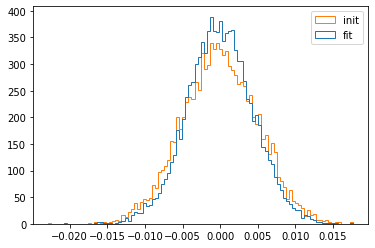

In [4]:
plt.hist([mom_fit[:, 2] - mom_mc[:, 2], 
          mom_init[:, 2] - mom_mc[:, 2]], 
            bins=100, histtype='step', label=['fit', 'init']);
plt.legend()

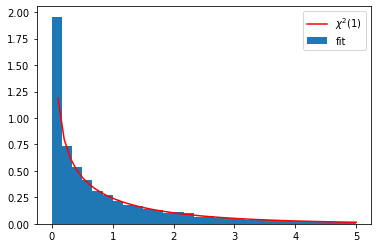

In [5]:
import scipy.stats as stats

x = np.linspace(0, 5)
plt.plot(x, stats.chi2.pdf(x, 1), 'r', label=r'$\chi^2(1)$')
plt.hist(chis, bins=30, range=(0, 5), density=True, label='fit');
plt.legend();

## Fit decay generated by `decay-gen`



In [6]:
sys.path.append("../generators/decay-gen")

import jax.random as rjax
import helixgen.resolution as res
from helixgen.phspdecay import generate

/home/ddyak/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
rng = rjax.PRNGKey(seed=1)

In [8]:
smearer = lambda rng, gp: res.apply_resolution(
    rng, gp,
    res.apply_resolution_neutral_cartesian,
    res.apply_resolution_charged_cartesian)

In [9]:
weights, genpcls = generate(rng, '', 10000, smearer)

In [10]:
genpcls.keys()

dict_keys(['pi+_Ks0', 'pi-_Ks0', 'Ks0', 'pi+', 'pi-'])

In [11]:
genpcls['pi+_Ks0'].keys()

dict_keys(['pcl', 'mom', 'pos', 'meas_pos', 'meas_mom', 'poscov', 'momcov', 'meas_hel', 'hel'])

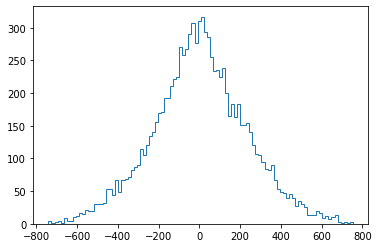

In [12]:
plt.hist((genpcls['pi+_Ks0']['mom'].px), histtype='step', bins=100);

In [13]:
genpcls['pi+'].keys()

dict_keys(['pcl', 'mom', 'pos', 'meas_pos', 'meas_mom', 'poscov', 'momcov', 'meas_hel', 'hel'])

In [14]:
genpcls['pi-_Ks0']['momcov']

DeviceArray([[[100.,   0.,   0.],
              [  0., 100.,   0.],
              [  0.,   0., 289.]],

             [[100.,   0.,   0.],
              [  0., 100.,   0.],
              [  0.,   0., 289.]],

             [[100.,   0.,   0.],
              [  0., 100.,   0.],
              [  0.,   0., 289.]],

             ...,

             [[100.,   0.,   0.],
              [  0., 100.,   0.],
              [  0.,   0., 289.]],

             [[100.,   0.,   0.],
              [  0., 100.,   0.],
              [  0.,   0., 289.]],

             [[100.,   0.,   0.],
              [  0., 100.,   0.],
              [  0.,   0., 289.]]], dtype=float32)

In [16]:
chis = []

pip_ks_m = genpcls['pi+_Ks0']['meas_mom'].as_array / 1e3
pim_ks_m = genpcls['pi-_Ks0']['meas_mom'].as_array / 1e3
pip_cov = genpcls['pi+_Ks0']['momcov'] / 1e6
pim_cov = genpcls['pi-_Ks0']['momcov'] / 1e6

pip_mom = []
pim_mom = []

for i in range(10000):
    pip_ks = Particle(211, momentum=pip_ks_m[i], cov=pip_cov[i])
    pim_ks = Particle(-211, momentum=pim_ks_m[i], cov=pim_cov[i])
    ks = Particle(311, daughters=[pip_ks, pim_ks])
    
    fm = FitManager(ks)
    fm.fit()

    pip_mom.append(pip_ks.momentum())
    pim_mom.append(pim_ks.momentum())

    chis.append(fm.chi2())

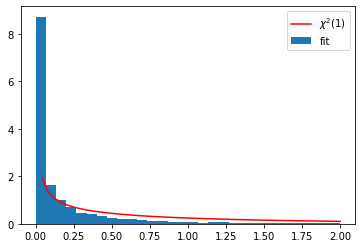

In [17]:
x = np.linspace(0, 2)
plt.plot(x, stats.chi2.pdf(x, 1), 'r', label=r'$\chi^2(1)$')
plt.hist(chis, bins=30, range=(0, 2), density=True, label='fit');
plt.legend();

In [18]:
pip_mom = np.array(pip_mom)
pim_mom = np.array(pim_mom)

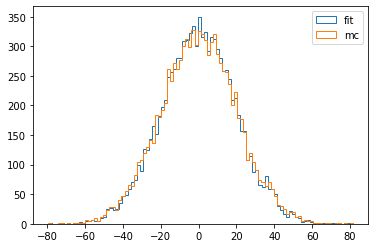

In [19]:
plt.hist(pip_mom[:, 0] * 1000 + pim_mom[:, 0] * 1000 - genpcls['Ks0']['mom'].as_array[:, 0], histtype='step', bins=100, label='fit');

plt.hist(genpcls['pi+_Ks0']['meas_mom'].as_array[:, 0] + genpcls['pi-_Ks0']['meas_mom'].as_array[:, 0] - genpcls['Ks0']['mom'].as_array[:, 0], histtype='step', bins=100, label='mc');
plt.legend()

In [ ]:
fit = (((pip_mom * 1000 + pim_mom * 1000) ** 2).sum(axis=1) + (497.614 ** 2)) ** 0.5

In [ ]:
ks_m = (genpcls['pi+_Ks0']['meas_mom'].as_array + genpcls['pi-_Ks0']['meas_mom'].as_array)
ks_e = ((ks_m ** 2).sum(axis=1) + (497.614 ** 2)) ** 0.5


In [ ]:
ks_mc = genpcls['Ks0']['mom'].energy(497.614)

In [ ]:
plt.hist(fit - ks_mc, histtype='step', bins=200, label='fit');
plt.hist(ks_e - ks_mc, histtype='step', bins=200, label='mc');
plt.legend()